# Apply regridding weights to data

See [compute_weights.ipynb](compute_weights.ipynb) for the previous step.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.sparse as sps
import sparse # https://github.com/mrocklin/sparse

try:
    import numba
except:
    print("numba not installed")

## Read regridding weights

In [2]:
ds_w = xr.open_dataset("weights.nc")
ds_w

<xarray.Dataset>
Dimensions:  (n_s: 480000)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 0.6247 0.2082 0.1253 0.04176 0.2082 0.6247 ...
    col      (n_s) int32 1 2 601 602 2 3 602 603 4 5 604 605 5 6 605 606 7 8 ...
    row      (n_s) int32 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 ...

In [3]:
n_s = ds_w.dims['n_s']
col = ds_w['col'].values - 1 # Python starts with 0
row = ds_w['row'].values - 1
S = ds_w['S'].values

In [4]:
row.max(), col.max(), S.max()

(119999, 239999, 0.62532626615536413)

## Sparse structure

In [5]:
B = sps.coo_matrix((S, (row, col))) 

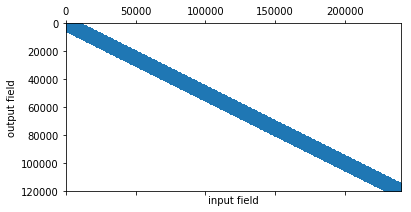

In [6]:
plt.spy( B )
plt.xlabel('input field');plt.ylabel('output field')

## Read input data

In [7]:
ds_in = xr.open_dataset('input_data.nc')
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (time, lev, y, x) float64 1.007 1.007 1.007 1.007 1.007 1.007 ...

## Read regridding results by ESMPy for comparision

In [8]:
ds_out = xr.open_dataset('output_data.nc')
ds_out

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 400, x_b: 401, y: 300, y_b: 301)
Coordinates:
    lon      (y, x) float64 -119.7 -119.1 -118.5 -117.9 -117.3 -116.7 -116.1 ...
    lat      (y, x) float64 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.4 -118.8 -118.2 -117.6 -117.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (time, lev, y, x) float64 1.009 1.009 1.01 1.01 1.01 1.01 1.01 ...

## Array shape tweaking

In [9]:
Ntime, Nlev, Nlat_in, Nlon_in  = ds_in['data'].shape
_, _, Nlat_out, Nlon_out= ds_out['data'].shape

extra_dims = [Ntime, Nlev]

In [10]:
data_in = ds_in['data'].values
data_in.shape

(10, 50, 400, 600)

In [11]:
data_in.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

## Flatten lat and lon dimensions for matrix multiplication

In [12]:
flat_in = data_in.reshape(*extra_dims, Nlat_in*Nlon_in)
flat_in.shape

(10, 50, 240000)

In [13]:
np.may_share_memory(data_in, flat_in)

True

# Applying weights using scipy sparse dot

In [14]:
B.shape

(120000, 240000)

In [15]:
flat_in.shape

(10, 50, 240000)

In [16]:
flat_flat_in = flat_in.reshape(-1, Nlat_in*Nlon_in)
flat_flat_in.shape

(500, 240000)

In [17]:
flat_flat_in.T.shape

(240000, 500)

In [18]:
%time flat_flat_out = B.dot(flat_flat_in.T).T
flat_flat_out.shape

CPU times: user 370 ms, sys: 230 ms, total: 600 ms
Wall time: 599 ms


(500, 120000)

In [19]:
flat_flat_out.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [20]:
dims_reshape_out = [*extra_dims, Nlat_out, Nlon_out]
dims_reshape_out

[10, 50, 300, 400]

In [21]:
data_out_by_scipy = flat_flat_out.reshape(dims_reshape_out)

In [22]:
data_out_by_scipy.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [23]:
np.allclose(ds_out['data'].values, data_out_by_scipy)

True

In [24]:
%%time
ds_out['outdata_scipy'] = (('time', 'lev', 'y', 'x'), data_out_by_scipy)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.19 ms


In [25]:
%time ds_out['outdata_scipy'].to_netcdf('test_write.nc')

CPU times: user 60 ms, sys: 160 ms, total: 220 ms
Wall time: 1.87 s


# Applying weights using loops

In [26]:
dims_out = [*extra_dims, Nlat_out*Nlon_out]
flat_out = np.zeros(dims_out) 

In [27]:
def regrid_apply(flat_in, flat_out, n_s, col, row):
    flat_out[...] = 0.0
    for i in range(n_s):
        # sparse matrix multiplication by hand
        # use ... to broadcast across extra dimensions
        flat_out[..., row[i]] += flat_in[..., col[i]]*S[i]

In [28]:
%time regrid_apply(flat_in, flat_out, n_s, col, row)

CPU times: user 6.38 s, sys: 0 ns, total: 6.38 s
Wall time: 6.39 s


In [29]:
np.allclose(ds_out['data'].values, 
            flat_out.reshape([*extra_dims, Nlat_out, Nlon_out]))

True

## Try numba

In [30]:
regrid_apply_jit = numba.jit(regrid_apply, nopython=True)
regrid_apply_jit(flat_in, flat_out, n_s, col, row) # compile it

In [31]:
%time regrid_apply_jit(flat_in, flat_out, n_s, col, row)

CPU times: user 3.24 s, sys: 0 ns, total: 3.24 s
Wall time: 3.22 s


In [32]:
np.allclose(ds_out['data'].values, 
            flat_out.reshape([*extra_dims, Nlat_out, Nlon_out]))

True

## Test IO

In [33]:
%%time
ds_out['outdata_loop'] = (('time', 'lev', 'y', 'x'),
                        flat_out.reshape([*extra_dims, Nlat_out, Nlon_out]))

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 1.48 ms


In [57]:
%time ds_out['outdata_loop'].to_netcdf("test_write.nc")

CPU times: user 110 ms, sys: 130 ms, total: 240 ms
Wall time: 1.71 s


# Sparse-tensor dot?

In [35]:
# make a sparse matrix
A = sparse.COO([S, (row, col)])
A.shape

(120000, 240000)

In [36]:
flat_in.shape, flat_in.T.shape

((10, 50, 240000), (240000, 50, 10))

**SMM would have the highest performance if extra dimensions are the fastest changing dimensions**

In [37]:
%time flat_in_T = flat_in.T.copy() # extra dimensions are the fastest changing dimensions
flat_in_T.shape

CPU times: user 400 ms, sys: 160 ms, total: 560 ms
Wall time: 562 ms


(240000, 50, 10)

In [38]:
flat_in_T.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [39]:
# fastest possible case
%time regrid_out_T = sparse.tensordot(A, flat_in_T, axes=([1],[0]))
regrid_out_T.shape

CPU times: user 230 ms, sys: 220 ms, total: 450 ms
Wall time: 450 ms


(120000, 50, 10)

In [40]:
regrid_out_T.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

**Unfortunately, for most of data, extra dimensions are the slowest changing dimensions**

In [41]:
%time regrid_out = sparse.tensordot(flat_in, A, axes=([-1], [1]))
regrid_out.shape

CPU times: user 520 ms, sys: 490 ms, total: 1.01 s
Wall time: 1.04 s


(10, 50, 120000)

In [42]:
regrid_out.flags # both False?

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

## Reshape to 4D

In [43]:
data_out = regrid_out.reshape([*extra_dims, Nlat_out, Nlon_out])

In [44]:
data_out.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [45]:
# exactly the same as reference result
np.allclose(ds_out['data'].values, data_out)

True

## Add to Dataset

In [46]:
%time ds_out['new_outdata'] = (('time', 'lev', 'y', 'x'), data_out)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.08 ms


In [47]:
ds_out['new_outdata'].values.flags 

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [48]:
np.may_share_memory(ds_out['new_outdata'].values, data_out)

True

In [49]:
%time ds_out['new_outdata'].to_netcdf('test_write.nc')

CPU times: user 1.79 s, sys: 550 ms, total: 2.34 s
Wall time: 3.84 s


## Memory layout of regridding result

data_out is closer to Fortran-ordering??

In [50]:
# copying to C-ordering is slow
%time data_out_C = data_out.copy()

CPU times: user 1.61 s, sys: 170 ms, total: 1.78 s
Wall time: 1.79 s


In [51]:
data_out_C.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [52]:
# copying to F-ordering is fast
%time data_out_F = np.asfortranarray(data_out)

CPU times: user 80 ms, sys: 110 ms, total: 190 ms
Wall time: 194 ms


In [53]:
data_out_F.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

**Will it affect I/O performance?**

In [54]:
ds_out['outdata_C_order'] = (('time', 'lev', 'y', 'x'), data_out_C)
ds_out['outdata_F_order'] = (('time', 'lev', 'y', 'x'), data_out_F)

In [55]:
%time ds_out['outdata_C_order'].to_netcdf('test_write.nc')

CPU times: user 10 ms, sys: 310 ms, total: 320 ms
Wall time: 1.87 s


In [56]:
%time ds_out['outdata_F_order'].to_netcdf('test_write.nc')

CPU times: user 3.34 s, sys: 400 ms, total: 3.74 s
Wall time: 5.28 s
